In [4]:
#https://www.xignite.com/Product/global-interest-rates#/productoverview 
#https://fiscaldata.treasury.gov/api-documentation/

In [159]:
#bring dependencies
from IPython.display import display
from IPython.display import display, HTML
from IPython.display import HTML
from pprint import pprint
from prettytable import PrettyTable
from tqdm import tqdm
from plotly.subplots import make_subplots
from config import api_key_bls
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import ipywidgets as widgets
import plotly.offline as pyo
import plotly as py
import plotly.graph_objs as go
import numpy as np
import pandas as pd
import geopandas as gpd
import requests
import json
import os
import scipy.stats as st
from IPython.display import display, HTML
import seaborn as sns


In [160]:
# The url for BLS API v2
url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'
key = '?registrationkey={}'.format(api_key_bls)


BDS0000000000000000110101LQ5 - Business Employment Dynamics
Business Employment Dynamics data are quarterly series of gross job gains and gross job losses statistics for the entire economy. These data track changes in employment at the establishment level, and thus provide a picture of the dynamics underlying aggregate net employment growth statistics.

- 1st plot the line graphic for jobs gain/loss
- 2nd calculated the mean and median for jobs gain/loss
- plot a bar graphic
- top 10 and bottom 10 jobs 2031 forecast




In [161]:
#series
headers = {'Content-type': 'application/json'} #contains info about the message- such as destination

# Submit the list of series as data - payload actual data being transmitted over a network
data = json.dumps({"seriesid": ['BDS0000000000000000110001LQ5',#Business Employment Dynamic - jobs Gain
                                'BDS0000000000000000110004LQ5',#Business Employment Dynamic - jobs loss
                                'BDS0000000000000000120001LQ5',#Business Employment Dynamic - stablishment gain
                                'BDS0000000000000000120004LQ5'#Business Employment Dynamic - stablishment loss
                                
                               ], 
                   'startyear':'2010', 'endyear':'2023',
                   'catalog':True,
                   'annualaverage':True,
                   "registrationkey": api_key_bls}, indent=4)
p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
json_data = json.loads(p.text)
p


<Response [200]>

In [162]:
#create a list to create a DF

list_columns= []


for series in json_data['Results']['series']:

     
    seriesId = series['seriesID']
    print(seriesId)
    
    if 'catalog' in series.keys():
        seasonality = series['catalog']['seasonality']
        survey_name = series['catalog']['survey_name']
        measure_data_type = series['catalog']['measure_data_type']
    
            
        if 'commerce_industry' in series['catalog'].keys():
            commerce_industry = series['catalog']['commerce_industry']
            
        else:
            commerce_industry = None
            
            
        if 'commerce_sector' in series['catalog'].keys():
            commerce_sector = series['catalog']['commerce_sector']
        else:
            commerce_sector = None
     
        if 'area' in series['catalog'].keys():
            area = series['catalog']['area']
        else:
            area = None
    
    
    
       # area= series['catalog']['area']
    else:
        seasonality = None
        survey_name = None
        measure_data_type = None
        commerce_industry = None
        commerce_sector = None
        area= None
    #add all variables & create a list to append to the list above
    
    
    for item in series['data']:
        year = item['year']
        period = item['period']
        periodName = item['periodName']
        value = item['value']
        
        
        list_columns.append([seriesId,seasonality,survey_name,measure_data_type,
                             commerce_industry,commerce_sector,area,year,period,periodName,value])
        
bls_df= pd.DataFrame(list_columns,columns=['seriesId','seasonality','survey_name','measure_data_type',
                             'commerce_industry','commerce_sector','area','year','period','periodName','value'])



bls_df.to_csv("bls.csv", index= False, header=True)





BDS0000000000000000110001LQ5
BDS0000000000000000110004LQ5
BDS0000000000000000120001LQ5
BDS0000000000000000120004LQ5


In [163]:
#BLS job gains/losses from 2010-2023

bed_df = bls_df.loc[(bls_df['seriesId'] == 'BDS0000000000000000110001LQ5') |
                     (bls_df['seriesId'] == 'BDS0000000000000000110004LQ5') ]
                     
bed_df.to_csv("bed.csv", index=False, header=True)


In [164]:
#validate the extracted data against data source https://data.bls.gov/timeseries/BDS0000000000000000110001LQ5
BED=bed_df[['seriesId','survey_name','measure_data_type','commerce_industry','area','year','period','value']]


In [165]:
# replace the row name 'row1' with 'new_row1'
new_bed_df = bed_df.replace({'BDS0000000000000000110001LQ5':'jobs Gains',
                              'BDS0000000000000000110004LQ5':'jobs Losses'})                   

In [166]:
#change column value to Integer
new_bed_df['value'] = new_bed_df['value'].astype(int)


In [167]:
# pitot the data plot 
# https://data.bls.gov/timeseries/BDS0000000000000000110001LQ5

new_bed_df_pivot = new_bed_df.pivot_table(index=['year'], columns='measure_data_type', values='value', aggfunc='sum')
new_bed_df_pivot

measure_data_type,Gross Job Gains,Gross Job Losses
year,,
2010,27113,25859
2011,27576,25484
2012,28122,25611
2013,28406,25967
2014,29271,26342
2015,29787,27303
2016,29729,28106
2017,30166,28145
2018,30394,28402


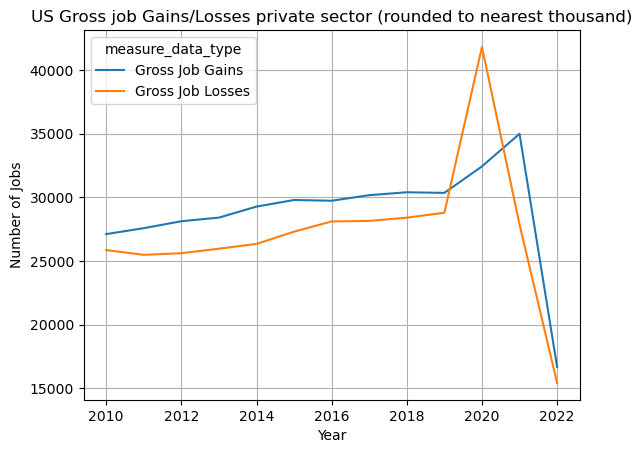

In [168]:
# plot the resulting DataFrame using the plot method
new_bed_df_pivot.plot(kind='line', ylabel='Number of Jobs', xlabel='Year', grid=True)
plt.title('US Gross job Gains/Losses private sector (rounded to nearest thousand)')
plt.savefig("job_G_L.png")
plt.show()

In [169]:
#change column value to Integer
new_bed_df_pivot['Gross Job Gains'] = new_bed_df_pivot['Gross Job Gains'].astype(int)
new_bed_df_pivot['Gross Job Losses'] = new_bed_df_pivot['Gross Job Losses'].astype(int)
#new_bed_df_pivot['year'] = new_bed_df_pivot['year'].astype(int)

In [170]:
# to calculate the average for job gains/losses and outliners

job_gains = new_bed_df_pivot["Gross Job Gains"]

mean_gain = np.mean(job_gains)

lowerqg = quartiles[0.25]
upperqg = quartiles[0.75]

lower_boundg = lowerq - (1.5*iqr)
upper_boundg = upperq + (1.5*iqr)

#Output - Gains
table = PrettyTable()
table.field_names = ["US job gains between 2010-2022"]
table.add_row(["_________________________________________________________________"])
table.add_row([f"Average job gain in the USA {mean_gain:.2f}"])
table.add_row([f"Lower quartile of job gains is: {lowerqg}"])
table.add_row([f"Upper quartile of job gains is: {upperqg}"])
table.add_row([f"Values of job gains below {lower_boundg} could be outliers"])
table.add_row([f"Values of job gains above {upper_boundg} could be outliers"])

# Set the format of the table
table.align = "l"
table.border = True

# Create a table object and add the table to the axis
ax.table(cellText=table.get_string().split('\n'), loc='center')

# Save the table as an image
plt.savefig("table_gain.png")
plt.show()
print(table)

#Output - Losses

job_losses = new_bed_df_pivot["Gross Job Losses"]
mean_loss = np.mean(job_losses)
lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)

table = PrettyTable()
table.field_names = ["US job losses between 2010-2022"]
table.add_row(["_________________________________________________________________"])
table.add_row([f"Average job losses in the USA {mean_loss:.2f}"])
table.add_row([f"Lower quartile of job losses is: {lowerq}"])
table.add_row([f"Upper quartile of job losses is: {upperq}"])
table.add_row([f"Values of job losses below {lower_bound} could be outliers"])
table.add_row([f"Values of job losses above {upper_bound} could be outliers"])

# Set the format of the table
table.align = "l"
table.border = True

# Create a table object and add the table to the axis
ax.table(cellText=table.get_string().split('\n'), loc='center')

# Save the table as an image
plt.savefig("table_loss.png")
plt.show()
print(table)


<Figure size 640x480 with 0 Axes>

+-------------------------------------------------------------------+
| US job gains between 2010-2022                                    |
+-------------------------------------------------------------------+
| _________________________________________________________________ |
| Average job gain in the USA 28846.62                              |
| Lower quartile of job gains is: 25859.0                           |
| Upper quartile of job gains is: 28145.0                           |
| Values of job gains below 22430.0 could be outliers               |
| Values of job gains above 31574.0 could be outliers               |
+-------------------------------------------------------------------+


<Figure size 640x480 with 0 Axes>

+-------------------------------------------------------------------+
| US job losses between 2010-2022                                   |
+-------------------------------------------------------------------+
| _________________________________________________________________ |
| Average job losses in the USA 27316.00                            |
| Lower quartile of job losses is: 25859.0                          |
| Upper quartile of job losses is: 28145.0                          |
| Values of job losses below 22430.0 could be outliers              |
| Values of job losses above 31574.0 could be outliers              |
+-------------------------------------------------------------------+


In [171]:
#read_CSV - https://data.bls.gov/projections/occupationProj
empl_proj_df = pd.read_csv("Employment Projections.csv")

In [172]:
new_proj_df = empl_proj_df[['Occupation Title',
                            'Employment Change, 2021-2031',
                            'Employment Percent Change, 2021-2031',
                            'Median Annual Wage 2021',
                            'Typical Entry-Level Education']]


In [173]:
# Sort the dataframe by 'Employment Change, 2021-2031' column
top_jobs_df = new_proj_df.sort_values(['Employment Change, 2021-2031'], ascending=False)

# Get the top 10 rows
top_jobs_df = top_jobs_df.head(10)
top_jobs_df.reset_index(drop=True)




,Occupation Title,"Employment Change, 2021-2031","Employment Percent Change, 2021-2031",Median Annual Wage 2021,Typical Entry-Level Education
0,Home health and personal care aides,924.0,25.4,"29,430",High school diploma or equivalent
1,"Cooks, restaurant * Banquet Cook* Breakfast...",459.9,36.6,"30,010",No formal educational credential
2,Software developers,370.6,26.0,"120,730",Bachelor's degree
3,Fast food and counter workers,243.2,7.6,"25,100",No formal educational credential
4,General and operations managers * Departmen...,209.8,6.7,"97,970",Bachelor's degree
5,Waiters and waitresses * Cocktail Server* C...,197.0,10.3,"26,000",No formal educational credential
6,Registered nurses * CCU Nurse* CNS* Clinica...,195.4,6.2,"77,600",Bachelor's degree
7,"Laborers and freight, stock, and material move...",168.4,6.0,"31,230",No formal educational credential
8,Stockers and order fillers,157.9,6.4,"30,110",High school diploma or equivalent
9,Market research analysts and marketing special...,150.3,19.0,"63,920",Bachelor's degree


In [174]:
# Sort the dataframe by 'Employment Change, 2021-2031' column
top_jobs_df = new_proj_df.sort_values(['Employment Change, 2021-2031'], ascending=False)

# Get the top 10 rows
top_jobs_df = top_jobs_df.head(10)

# Convert the first dataframe to an HTML table
html_table_top = top_jobs_df.head(10).to_html(index=False, max_rows=None, max_cols=None, table_id='TopJobs')

# Set the column widths
col_widths = [0.3, 0.7]

# Display the HTML table

#display(HTML(html_table_top))

#with open("top_jobs_table.html", "w") as file:
#    file.write(html_table_top)


In [175]:
#sort values descending %
top_jobs_df=new_proj_df.sort_values(['Employment Percent Change, 2021-2031'], ascending=False)
top_jobs_df.head(10)

# Convert the first dataframe to an HTML table
html_table_top_perc = top_jobs_df.head(10).to_html(index=False, max_rows=None, max_cols=None, table_id='TopJobs%')

# Set the column widths
col_widths = [0.3, 0.7]

# Concatenate the HTML tables
html_tables = html_table_top + html_table_top_perc
# Display the HTML table

display(HTML(html_tables))

with open("tables.html", "w") as file:
    file.write(html_table_top)


Occupation Title,"Employment Change, 2021-2031","Employment Percent Change, 2021-2031",Median Annual Wage 2021,Typical Entry-Level Education
Home health and personal care aides,924.0,25.4,"29,430",High school diploma or equivalent
"Cooks, restaurant * Banquet Cook* Breakfast Cook* Chef De Partie* Line Cook* Saucier* Specialty Cook",459.9,36.6,"30,010",No formal educational credential
Software developers,370.6,26.0,"120,730",Bachelor's degree
Fast food and counter workers,243.2,7.6,"25,100",No formal educational credential
General and operations managers * Department Store General Manager* General Manager* General Superintendent* Manufacturing Operations Manager* Operations Manager* Radio Station Manager* Television Station Manager,209.8,6.7,"97,970",Bachelor's degree
Waiters and waitresses * Cocktail Server* Cocktail Waitress* Dining Car Server* Restaurant Server* Wine Steward,197.0,10.3,"26,000",No formal educational credential
Registered nurses * CCU Nurse* CNS* Clinical Nurse Specialist* Community Health Nurse* Coronary Care Unit Nurse* Emergency Room RN* Endoscopy Registered Nurse* Hospice Registered Nurse* Obstetrical Nurse* Oncology Registered Nurse* PACU Nurse* Pediatric Registered Nurse* Post-Anesthesia Care Unit Nurse* Psychiatric Nurse* RN* Registered Nurse* Triage Registered Nurse,195.4,6.2,"77,600",Bachelor's degree
"Laborers and freight, stock, and material movers, hand * Cargo Handler* Cart Pusher* Freight Handler* Grave Digger* Manufacturing Laborer* Material Handler* Package Handler* Shipping and Receiving Material Handler* Stock Mover* Van Loader* Wharf Laborer",168.4,6.0,"31,230",No formal educational credential
Stockers and order fillers,157.9,6.4,"30,110",High school diploma or equivalent
Market research analysts and marketing specialists * Market Research Analyst* Market Research Specialist* Marketing Analyst* Marketing Consultant* Marketing Forecaster* Marketing Specialist,150.3,19.0,"63,920",Bachelor's degree


In [176]:
#sort values ascending
top_jobs_df=new_proj_df.sort_values(['Employment Change, 2021-2031'], ascending=True)
top_jobs_df.reset_index(drop=True).head(10)
top_jobs_df


,Occupation Title,"Employment Change, 2021-2031","Employment Percent Change, 2021-2031",Median Annual Wage 2021,Typical Entry-Level Education
102,Cashiers * Cash Register Operator* Check Ou...,-335.7,-10.0,"27,260",No formal educational credential
708,"Secretaries and administrative assistants, exc...",-207.6,-10.0,"37,880",High school diploma or equivalent
560,"Office clerks, general * Administrative Cle...",-130.8,-4.8,"37,030",High school diploma or equivalent
185,Customer service representatives * Complain...,-105.3,-3.6,"36,920",High school diploma or equivalent
266,Executive secretaries and executive administra...,-102.6,-20.2,"62,060",High school diploma or equivalent
...,...,...,...,...,...
359,General and operations managers * Departmen...,209.8,6.7,"97,970",Bachelor's degree
286,Fast food and counter workers,243.2,7.6,"25,100",No formal educational credential
739,Software developers,370.6,26.0,"120,730",Bachelor's degree
163,"Cooks, restaurant * Banquet Cook* Breakfast...",459.9,36.6,"30,010",No formal educational credential


In [177]:
#sort values ascending
top_jobs_df=new_proj_df.sort_values(['Employment Change, 2021-2031'], ascending=True)
top_jobs_df.reset_index(drop=True).head(10)

,Occupation Title,"Employment Change, 2021-2031","Employment Percent Change, 2021-2031",Median Annual Wage 2021,Typical Entry-Level Education
0,Cashiers * Cash Register Operator* Check Ou...,-335.7,-10.0,"27,260",No formal educational credential
1,"Secretaries and administrative assistants, exc...",-207.6,-10.0,"37,880",High school diploma or equivalent
2,"Office clerks, general * Administrative Cle...",-130.8,-4.8,"37,030",High school diploma or equivalent
3,Customer service representatives * Complain...,-105.3,-3.6,"36,920",High school diploma or equivalent
4,Executive secretaries and executive administra...,-102.6,-20.2,"62,060",High school diploma or equivalent
5,Miscellaneous assemblers and fabricators,-96.4,-7.1,"36,590",High school diploma or equivalent
6,First-line supervisors of retail sales workers...,-78.2,-5.2,"39,230",High school diploma or equivalent
7,"Bookkeeping, accounting, and auditing clerks ...",-77.2,-4.5,"45,560","Some college, no degree"
8,"Cooks, fast food * Fast Food Cook* Fast Foo...",-69.1,-8.7,"24,180",No formal educational credential
9,"Shipping, receiving, and inventory clerks *...",-57.1,-7.0,"36,890",High school diploma or equivalent


In [178]:
# Load the project data
new_proj_df = pd.read_csv("Employment Projections.csv")

# Define the function to update the table based on the user input
def update_table(change):
    value = change['new']
    print(f"Filtering by value: {value}")
    filtered = new_proj_df[new_proj_df['Occupation Title'].str.contains(value, case=False)]
    print(filtered.head()) # print the first 5 rows of the filtered DataFrame for debugging
    table_html = filtered.to_html(index=False)
    table.value = table_html

# Create a text box for the user input
search_box = widgets.Text(placeholder='Search by occupation title')

# Call the update_table function when the user input changes
search_box.observe(update_table, names='value')

# Create the initial table
table_html = new_proj_df.to_html(index=False)
table = widgets.HTML(value=table_html)

# Display the search box and the table
display(search_box)
display(table)


Text(value='', placeholder='Search by occupation title')

HTML(value='<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th>Oc…

In [179]:
#series
headers = {'Content-type': 'application/json'} #contains info about the message- such as destination

# Submit the list of series as data - payload actual data being transmitted over a network
data = json.dumps({"seriesid": ['CUSR0000SA0',#CPI for All Urban Consumers (CPI-U)
                                                               ], 
                   'startyear':'2010', 'endyear':'2023',
                   'catalog':True,
                   'annualaverage':True,
                   "registrationkey": api_key_bls}, indent=4)
p2 = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
json_data = json.loads(p.text)
p2.json()

{'status': 'REQUEST_SUCCEEDED',
 'responseTime': 262,
 'message': [],
 'Results': {'series': [{'seriesID': 'CUSR0000SA0',
    'catalog': {'series_title': 'All items in U.S. city average, all urban consumers, seasonally adjusted',
     'series_id': 'CUSR0000SA0',
     'seasonality': 'Seasonally Adjusted',
     'survey_name': 'CPI for All Urban Consumers (CPI-U)',
     'survey_abbreviation': 'CU',
     'measure_data_type': 'All items',
     'area': 'U.S. city average',
     'item': 'All items'},
    'data': [{'year': '2023',
      'period': 'M02',
      'periodName': 'February',
      'latest': 'true',
      'value': '301.648',
      'footnotes': [{}]},
     {'year': '2023',
      'period': 'M01',
      'periodName': 'January',
      'value': '300.536',
      'footnotes': [{}]},
     {'year': '2022',
      'period': 'M12',
      'periodName': 'December',
      'value': '298.990',
      'footnotes': [{}]},
     {'year': '2022',
      'period': 'M11',
      'periodName': 'November',
      

In [180]:
#create a list to create a DF

list_columns= []


for series in json_data['Results']['series']:

     
    seriesId = series['seriesID']
    print(seriesId)
    
    if 'catalog' in series.keys():
        seasonality = series['catalog']['seasonality']
        survey_name = series['catalog']['survey_name']
        measure_data_type = series['catalog']['measure_data_type']
       
            
        if 'commerce_industry' in series['catalog'].keys():
            commerce_industry = series['catalog']['commerce_industry']
            
        else:
            commerce_industry = None
            
            
        if 'commerce_sector' in series['catalog'].keys():
            commerce_sector = series['catalog']['commerce_sector']
        else:
            commerce_sector = None
     
        if 'area' in series['catalog'].keys():
            area = series['catalog']['area']
        else:
            area = None
    
    
    
       # area= series['catalog']['area']
    else:
        seasonality = None
        survey_name = None
        measure_data_type = None
        commerce_industry = None
        commerce_sector = None
        area= None
    #add all variables & create a list to append to the list above
    
    
    for item in series['data']:
        year = item['year']
        period = item['period']
        periodName = item['periodName']
        value = item['value']
        
        
        list_columns.append([seriesId,seasonality,survey_name,measure_data_type,
                             commerce_industry,commerce_sector,item,area,year,period,periodName,value])
        
inflation_df= pd.DataFrame(list_columns,columns=['seriesId','seasonality','survey_name','measure_data_type',
                             'commerce_industry','commerce_sector','item','area','year','period','periodName','value'])


inflation_df.to_csv("inflation.csv", index= False, header=True)




BDS0000000000000000110001LQ5
BDS0000000000000000110004LQ5
BDS0000000000000000120001LQ5
BDS0000000000000000120004LQ5


In [181]:
inflation_df.columns

Index(['seriesId', 'seasonality', 'survey_name', 'measure_data_type',
       'commerce_industry', 'commerce_sector', 'item', 'area', 'year',
       'period', 'periodName', 'value'],
      dtype='object')

In [182]:
#change column value to Integer
inflation_df['value'] = inflation_df['value'].apply(lambda x:float(x))

In [187]:
#https://data.bls.gov/apps/covid-dashboard/home.htm
state_unp_rate_df = pd.read_csv("State_unemployement_rate.bls_table.csv")
state_unp_rate_df.head()

,State,Jan-15,Feb-15,Mar-15,Apr-15,May-15,Jun-15,Jul-15,Aug-15,Sep-15,...,Apr-22,May-22,Jun-22,Jul-22,Aug-22,Sep-22,Oct-22,Nov-22,Dec-22,Jan-23
0,Alabama,6.1,6.1,6.1,6.1,6.1,6.2,6.2,6.2,6.1,...,2.5,2.5,2.6,2.6,2.6,2.6,2.6,2.6,2.6,2.6
1,Alaska,6.2,6.3,6.3,6.3,6.3,6.3,6.2,6.2,6.2,...,4.1,3.9,3.9,3.8,3.6,3.7,3.8,3.7,3.7,3.8
2,Arizona,6.4,6.3,6.2,6.2,6.1,6.1,6.1,6.0,6.0,...,3.6,3.7,3.8,3.9,4.0,4.0,4.1,4.0,4.0,3.8
3,Arkansas,5.5,5.4,5.4,5.3,5.2,5.1,4.9,4.8,4.6,...,3.1,3.2,3.2,3.3,3.4,3.5,3.5,3.5,3.4,3.4
4,California,6.8,6.7,6.6,6.5,6.4,6.3,6.2,6.0,5.9,...,4.1,4.0,3.9,3.8,3.8,4.0,4.1,4.1,4.1,4.2
